Normalizes, trims, and filters NINFEADB file

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
from scipy.signal import butter, filtfilt, sosfiltfilt, decimate

In [10]:
# Enter dataset you want to preprocess
dataset = 'tpehgt'

In [11]:
# Print dataset info
data_path = os.path.join("..", "Source Data","Original Data", dataset + '_data.npy')
data = np.load(data_path, allow_pickle=True)

# Print basic dataset info
print(f"Total number of entries: {len(data)}")
print(f"First entry keys: {list(data[0].keys())}")  # Check the dictionary structure

# Extract sequence lengths
sequence_lengths = np.array([entry['signal'].shape[0] for entry in data])

# Compute statistics
print(f"Max sequence length: {np.max(sequence_lengths)}")
print(f"Min sequence length: {np.min(sequence_lengths)}")
print(f"Mean sequence length: {np.mean(sequence_lengths):.2f}")
print(f"Standard deviation of sequence lengths: {np.std(sequence_lengths):.2f}")

# Check number of channels
num_channels = set(entry['signal'].shape[1] for entry in data)
print(f"Unique number of channels in dataset: {num_channels}")

# Print a sample metadata entry
print("Sample metadata:", {k: v for k, v in data[0].items() if k != 'signal'})
print(data[0]['metadata']['fs'])
print('Number of channels: ', data[0]['signal'].shape[1])

Total number of entries: 31
First entry keys: ['record_name', 'signal', 'metadata']
Max sequence length: 36000
Min sequence length: 35200
Mean sequence length: 35888.03
Standard deviation of sequence lengths: 256.61
Unique number of channels in dataset: {8}
Sample metadata: {'record_name': 'tpehgt_n001', 'metadata': {'fs': 20, 'sig_len': 35300, 'n_sig': 8, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'comments': ['Comments:', 'RecID\ttpehgt_n001', 'RecType Non-pregnant', 'Gestation N/A', 'Rectime N/A', 'Age None', 'Parity None', 'Abortions None', 'Weight None', 'Placental_position N/A', 'Smoker None']}}
20
Number of channels:  8


In [12]:
# Function to plot signals
def plot_signals(signal, title, filename):
    num_channels = signal.shape[1]
    fig, axes = plt.subplots(num_channels, 1, figsize=(12, 2 * num_channels), sharex=True)

    for i in range(num_channels):
        axes[i].plot(signal[:, i], label=f'Channel {i+1}')
        axes[i].legend(loc='upper right')
        axes[i].set_ylabel("Amplitude")

    axes[-1].set_xlabel("Time Steps")
    fig.suptitle(title)
    
    # Save the figure
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    # plt.close()
    plt.show()




In [13]:

def trim_data(data, sec_to_remove, dataset_name=None):
    """
    Trim the first and last `sec_to_remove` seconds from each sequence in the dataset.
    Returns a new dataset with trimmed signals.
    """
    trimmed_data = []
    
    for entry in data:
        sampling_frequency = int(entry['metadata']['fs'])
        ts_to_remove = sec_to_remove * sampling_frequency
        
        signal = entry['signal']
        trimmed_signal = signal[ts_to_remove:-ts_to_remove] if 2 * ts_to_remove < len(signal) else signal
        
        # Remove specific channels if dataset is 'ninfea'
        if dataset == 'ninfea':
            print('will remove channels')
            channels_to_remove = [27, 28, 29, 30, 32, 33]
            trimmed_signal = np.delete(trimmed_signal, channels_to_remove, axis=1)
        
        # Remove last two channels if dataset is 'tpehgt'
        if dataset == 'tpehgt':
            print('removes TOCO channels from tpehgt')
            trimmed_signal = trimmed_signal[:, :-2]

        trimmed_data.append({
            'record_name': entry['record_name'],
            'signal': trimmed_signal,
            'metadata': entry['metadata']
        })
    
    return trimmed_data
    
trimmed_data = trim_data(data, 60)
trimmed_sequence_lengths = np.array([entry['signal'].shape[0] for entry in trimmed_data])
# Compute statistics
print(f"Max sequence length before trimming: {np.max(sequence_lengths)}")
print(f"Min sequence length before trimming: {np.min(sequence_lengths)}")
print(f"Max sequence length after trimming: {np.max(trimmed_sequence_lengths)}")
print(f"Min sequence length after trimming: {np.min(trimmed_sequence_lengths)}")

removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO channels from tpehgt
removes TOCO c

In [14]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a Butterworth bandpass filter to the signal.
    """
    b, a = butter(order, highcut, 'high', fs=fs)
    y = filtfilt(b, a, data, axis=0)
    b, a = butter(order, lowcut, 'low', fs=fs)
    return filtfilt(b, a, y, axis=0)

def filter_data(data, bandwidth=[0.34, 0.4]):
    """
    Filter each channel of the signal within the specified bandwidth.
    """
    filtered_data = []
    
    for entry in data:
        signal = entry['signal']
        fs = entry['metadata']['fs']
        
        # Apply bandpass filter
        filtered_signal = butter_bandpass_filter(signal, lowcut=bandwidth[0], highcut=bandwidth[1], fs=fs)
        
        filtered_data.append({
            'record_name': entry['record_name'],
            'signal': filtered_signal,
            'metadata': entry['metadata']
        })
    
    return filtered_data


filtered_data = filter_data(trimmed_data)

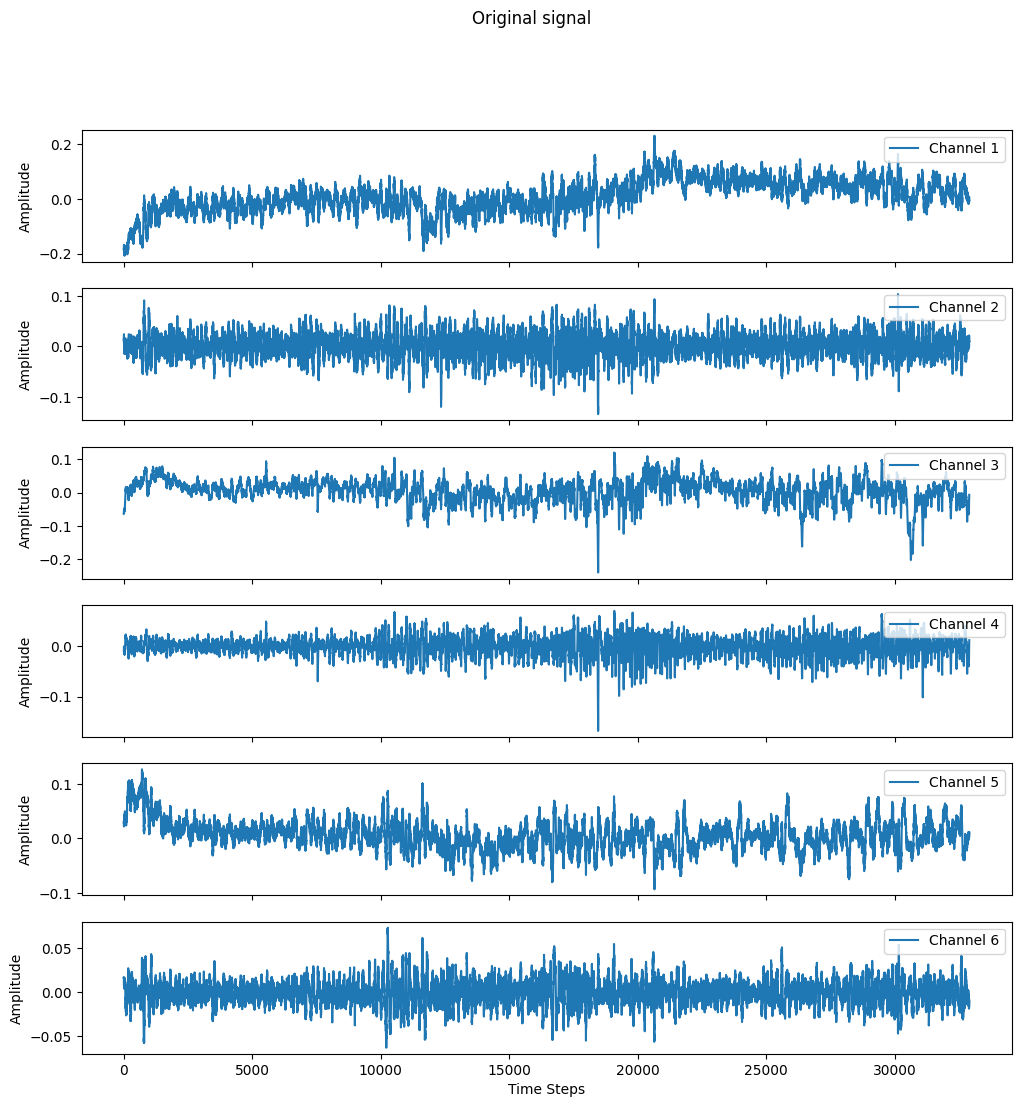

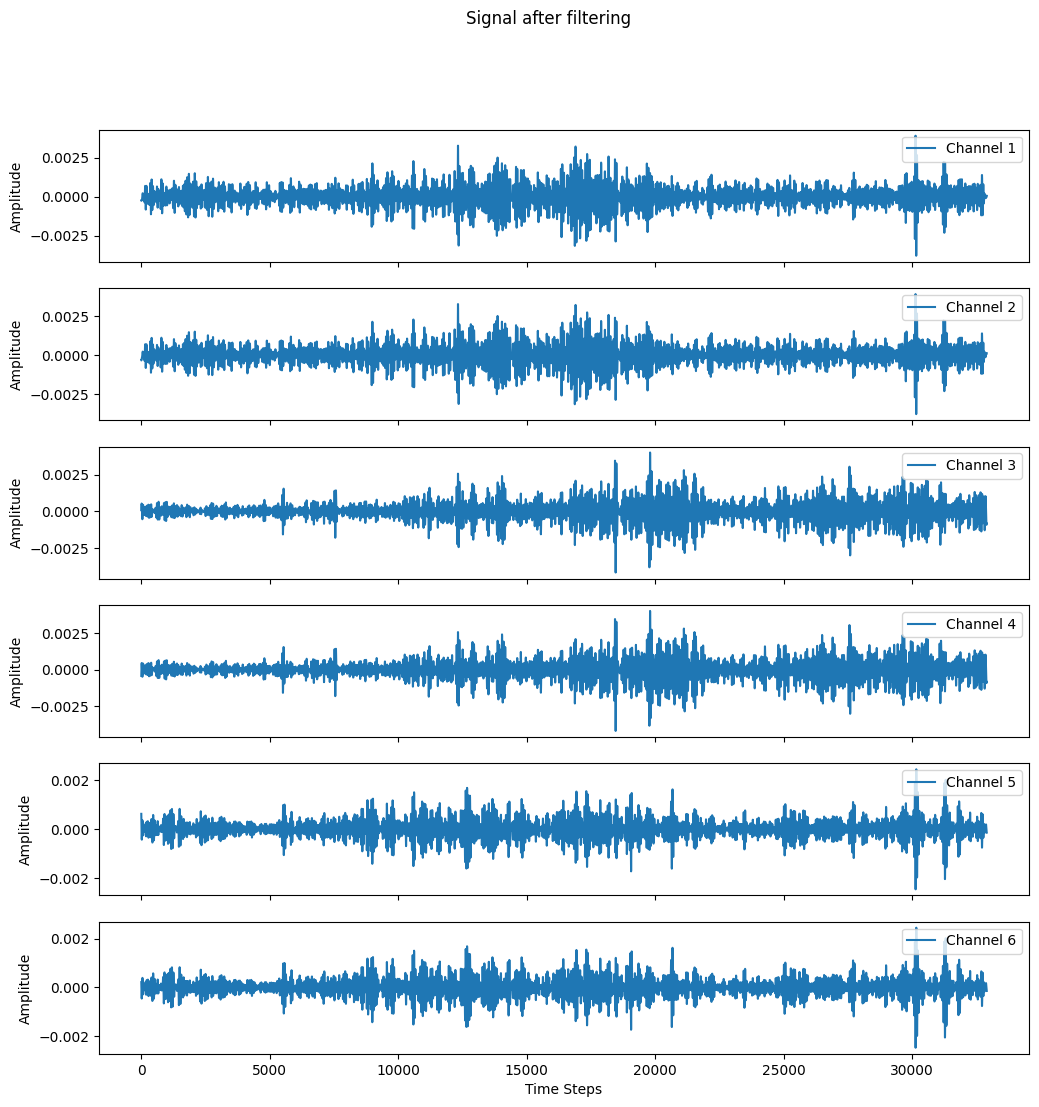

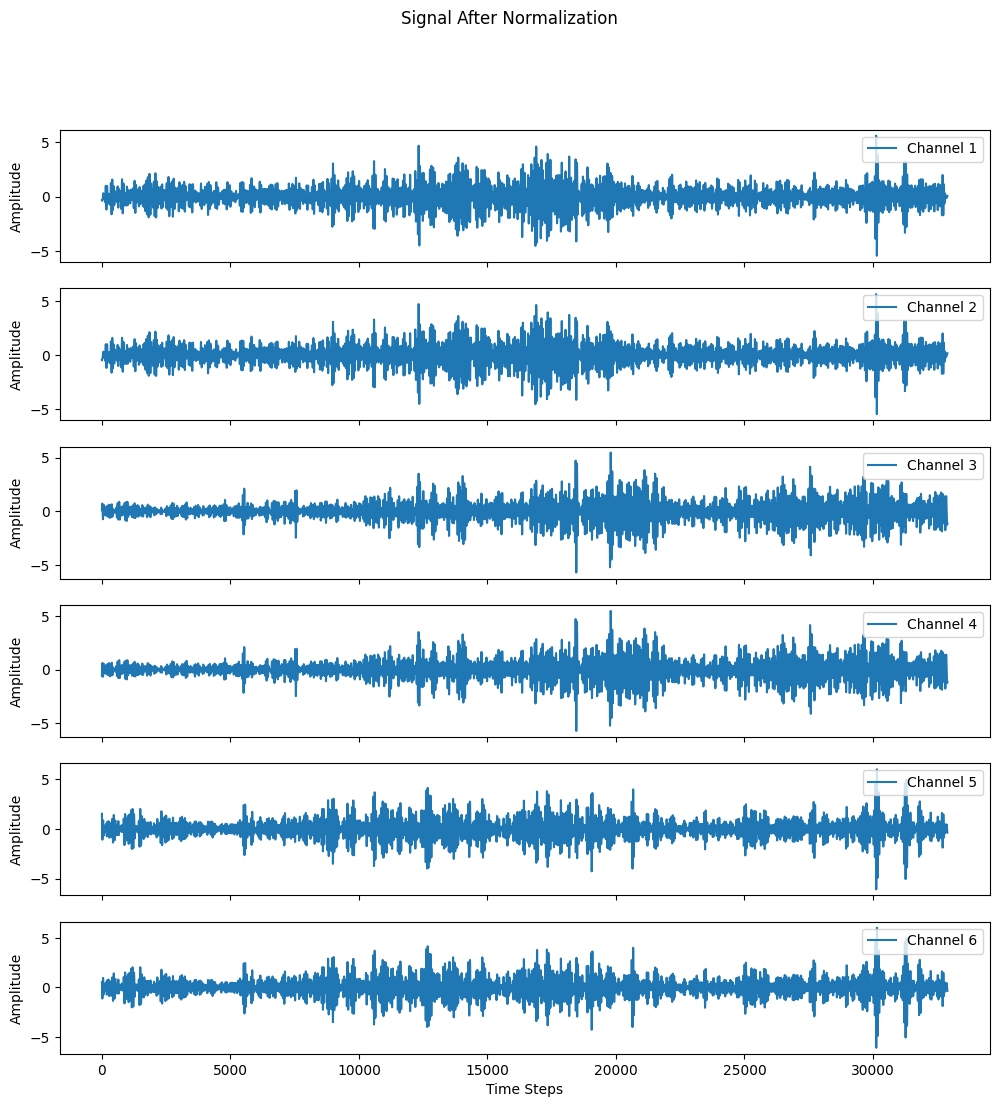

In [15]:

def z_normalize_signals(data, epsilon=1e-8):
    """
    Apply z-normalization to each channel in the multivariate time series dataset.
    """
    normalized_entries = []
    
    for entry in data:
        signal = entry['signal']  # Shape: (sequence_length, num_channels)
        
        if signal.ndim == 1:
            signal = signal[:, np.newaxis]  # Ensure 2D array for consistency
        
        # Compute mean and std for each channel separately
        mu = np.mean(signal, axis=0)
        sigma = np.std(signal, axis=0)
        
        # Normalize each channel
        normalized_signal = (signal - mu) / (sigma + epsilon)
        
        # Store the normalized entry
        normalized_entries.append({
            'record_name': entry['record_name'],
            'signal': normalized_signal
        })
    
    return normalized_entries

# Apply normalization
normalized_data = z_normalize_signals(filtered_data)

original_signal = trimmed_data[0]['signal']
filtered_signal = filtered_data[0]['signal']
normalized_signal = normalized_data[0]['signal']

# # # Plot before and after normalization
plot_signals(original_signal, "Original signal", "../Source Data/Data Plots/before_norm_nifeadb.png")
plot_signals(filtered_signal, "Signal after filtering", "../Source Data/Data Plots/before_norm_nifeadb.png")
plot_signals(normalized_signal, "Signal After Normalization", "../../Source Data/Data Plots/after_norm_nifeadb.png")

# Save the processed (normalized) data
normalized_data_path = os.path.join("..", "Source Data", "Normalized Data", dataset + "_preprocessed.npy")
np.save(normalized_data_path, normalized_data)

In [16]:

def check_normalize(data, tol=1e-2):
    """
    Check if the normalized dataset has mean ~0 and variance ~1 for each channel.
    """
    all_correct = True
    incorrect_entries = []
    
    for entry in data:
        signal = entry['signal']
        mean_per_channel = np.mean(signal, axis=0)
        std_per_channel = np.std(signal, axis=0)
        
        incorrect = np.where((np.abs(mean_per_channel) >= tol) | (np.abs(std_per_channel - 1) >= tol))[0]
        if len(incorrect) > 0:
            all_correct = False
            incorrect_entries.append((entry['record_name'], incorrect, mean_per_channel[incorrect], std_per_channel[incorrect]))
    
    if all_correct:
        print("Normalization check passed: All channels have mean ≈ 0 and std ≈ 1.")
    else:
        print("Normalization check failed: Some channels deviate from expected mean and std.")
        for record_name, incorrect, means, stds in incorrect_entries:
            print(f"Record {record_name}: ")
            for ch, mean, std in zip(incorrect, means, stds):
                print(f"  Channel {ch}: mean = {mean:.4f}, std = {std:.4f}")


        
check_normalize(normalized_data)

Normalization check passed: All channels have mean ≈ 0 and std ≈ 1.
